In [0]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

## Downloading the data

The cats vs. dogs dataset that we will use isn't packaged with Keras. It was made available by Kaggle.com as part of a computer vision 
competition in late 2013, back when convnets weren't quite mainstream. You can download the original dataset at: 
`https://www.kaggle.com/c/dogs-vs-cats/data` (you will need to create a Kaggle account if you don't already have one -- don't worry, the 
process is painless).

The pictures are medium-resolution color JPEGs. They look like this:

![cats_vs_dogs_samples](https://s3.amazonaws.com/book.keras.io/img/ch5/cats_vs_dogs_samples.jpg)

A training set with 1000 samples of each class, a validation 
set with 500 samples of each class, and finally a test set with 500 samples of each class.

Here are a few lines of code to do this:

In [0]:
from google.colab import drive, files
drive.mount('/content/drive/')
path = "/content/drive/My Drive/datasets/dogs-cats-sep/"

train_dir = path + "train"
validation_dir = path + "validation"
test_dir = path + "test"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).



So we have indeed 2000 training images, and then 1000 validation images and 1000 test images. In each split, there is the same number of 
samples from each class: this is a balanced binary classification problem, which means that classification accuracy will be an appropriate 
measure of success.

## Building our network

Since we are dealing with bigger images and a more complex problem, we will make our network accordingly larger: it will have one 
more `Conv2D` + `MaxPooling2D` stage. This serves both to augment the capacity of the network, and to further reduce the size of the 
feature maps, so that they aren't overly large when we reach the `Flatten` layer. Here, since we start from inputs of size 150x150 (a 
somewhat arbitrary choice), we end up with feature maps of size 7x7 right before the `Flatten` layer.

Note that the depth of the feature maps is progressively increasing in the network (from 32 to 128), while the size of the feature maps is 
decreasing (from 148x148 to 7x7). This is a pattern that you will see in almost all convnets.

Since we are attacking a binary classification problem, we are ending the network with a single unit (a `Dense` layer of size 1) and a 
`sigmoid` activation. This unit will encode the probability that the network is looking at one class or the other.

In [0]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Let's take a look at how the dimensions of the feature maps change with every successive layer:

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)       147584    
__________

For our compilation step, we'll go with the `RMSprop` optimizer. Since we ended our network with a single sigmoid unit, we will 
use binary crossentropy as our loss

In [0]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

## Data preprocessing

Currently, our data sits on a drive as JPEG files, so the steps for getting it into our network are roughly:

* Read the picture files.
* Decode the JPEG content to RBG grids of pixels.
* Convert these into floating point tensors.
* Rescale the pixel values (between 0 and 255) to the [0, 1] interval

In [0]:
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2010 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Let's take a look at the output of one of these generators: it yields batches of 150x150 RGB images (shape `(20, 150, 150, 3)`) and binary 
labels (shape `(20,)`). 20 is the number of samples in each batch (the batch size). Note that the generator yields these batches 
indefinitely: it just loops endlessly over the images present in the target folder. For this reason, we need to `break` the iteration loop 
at some point.

In [0]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


Let's fit our model to the data using the generator. We do it using the `fit_generator` method, the equivalent of `fit` for data generators 
like ours. It expects as first argument a Python generator that will yield batches of inputs and targets indefinitely, like ours does. 
Because the data is being generated endlessly, the generator needs to know example how many samples to draw from the generator before 
declaring an epoch over. This is the role of the `steps_per_epoch` argument: after having drawn `steps_per_epoch` batches from the 
generator, i.e. after having run for `steps_per_epoch` gradient descent steps, the fitting process will go to the next epoch. In our case, 
batches are 20-sample large, so it will take 100 batches until we see our target of 2000 samples.

When using `fit_generator`, one may pass a `validation_data` argument, much like with the `fit` method. Importantly, this argument is 
allowed to be a data generator itself, but it could be a tuple of Numpy arrays as well. If you pass a generator as `validation_data`, then 
this generator is expected to yield batches of validation data endlessly, and thus you should also specify the `validation_steps` argument, 
which tells the process how many batches to draw from the validation generator for evaluation.

In [0]:
import time

start = time.time()
print("hello")

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

end = time.time()
print(end - start)

hello
Epoch 1/30
100/100 [==============================] - 530s 5s/step - loss: 0.6865 - acc: 0.5465 - val_loss: 0.6814 - val_acc: 0.5480
Epoch 2/30
100/100 [==============================] - 144s 1s/step - loss: 0.6438 - acc: 0.6270 - val_loss: 0.6344 - val_acc: 0.6370
Epoch 3/30
100/100 [==============================] - 145s 1s/step - loss: 0.5919 - acc: 0.6815 - val_loss: 0.5917 - val_acc: 0.6710
Epoch 4/30
100/100 [==============================] - 145s 1s/step - loss: 0.5461 - acc: 0.7185 - val_loss: 0.6050 - val_acc: 0.6790
Epoch 5/30
100/100 [==============================] - 145s 1s/step - loss: 0.5325 - acc: 0.7355 - val_loss: 0.5820 - val_acc: 0.7000
Epoch 6/30
100/100 [==============================] - 147s 1s/step - loss: 0.5018 - acc: 0.7460 - val_loss: 0.5665 - val_acc: 0.7070
Epoch 7/30
100/100 [==============================] - 147s 1s/step - loss: 0.4664 - acc: 0.7725 - val_loss: 0.5839 - val_acc: 0.7030
Epoch 8/30
100/100 [==============================] - 146s 1s/s

In [0]:
model.save('/content/drive/My Drive/cats_and_dogs_small_1.h5')

Let's plot the loss and accuracy of the model over the training and validation data during training:

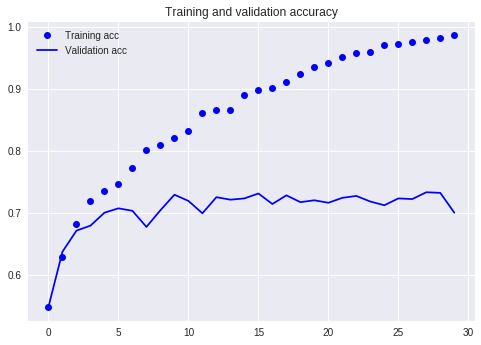

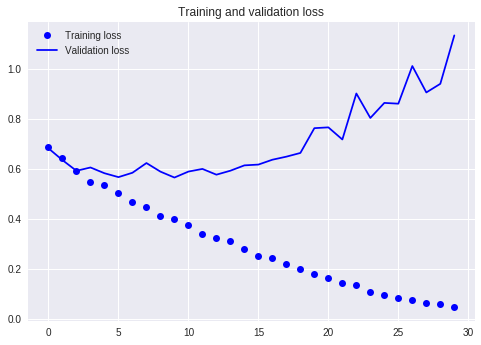

In [0]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

These plots are characteristic of overfitting. Our training accuracy increases linearly over time, until it reaches nearly 100%, while our 
validation accuracy stalls at 70-72%. Our validation loss reaches its minimum after only five epochs then stalls, while the training loss 
keeps decreasing linearly until it reaches nearly 0.

Because we only have relatively few training samples (2000), overfitting is going to be our number one concern. We are now going to use a technique used almost universally when processing images with deep learning models: *data 
augmentation*.

## Using data augmentation

In Keras, this can be done by configuring a number of random transformations to be performed on the images read by our `ImageDataGenerator` 
instance.

In [0]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

These are just a few of the options available (for more, see the Keras documentation). Let's quickly go over what we just wrote:

* `rotation_range` is a value in degrees (0-180), a range within which to randomly rotate pictures.
* `width_shift` and `height_shift` are ranges (as a fraction of total width or height) within which to randomly translate pictures 
vertically or horizontally.
* `shear_range` is for randomly applying shearing transformations.
* `zoom_range` is for randomly zooming inside pictures.
* `horizontal_flip` is for randomly flipping half of the images horizontally -- relevant when there are no assumptions of horizontal 
asymmetry (e.g. real-world pictures).
* `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

Let's take a look at our augmented images:

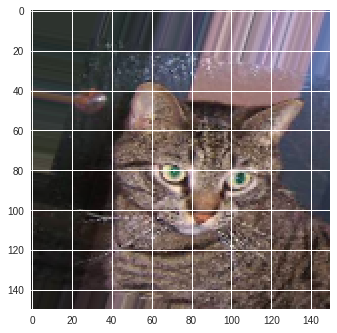

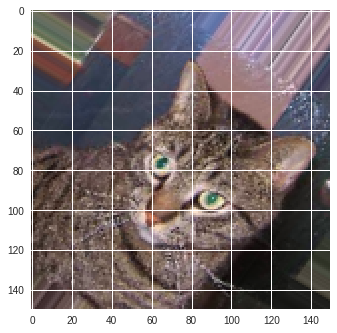

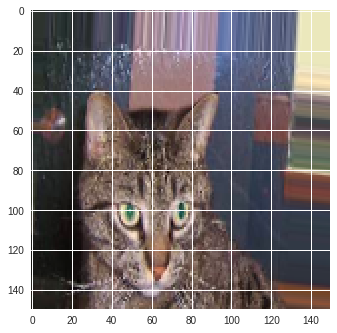

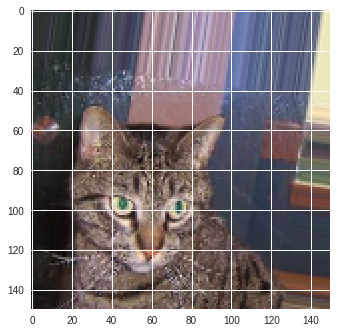

In [0]:
# This is module with image preprocessing utilities
from keras.preprocessing import image
from google.colab import files

# We pick one image to "augment"
img_path = train_dir + '/cats/cat.1.jpg'

# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

If we train a new network using this data augmentation configuration, our network will never see twice the same input. However, the inputs 
that it sees are still heavily intercorrelated, since they come from a small number of original images -- we cannot produce new information, 
we can only remix existing information. As such, this might not be quite enough to completely get rid of overfitting. To further fight 
overfitting, we will also add a Dropout layer to our model, right before the densely-connected classifier:

In [0]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

Let's train our network using data augmentation and dropout:

In [0]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Found 2010 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 255s 3s/step - loss: 0.6931 - acc: 0.5328 - val_loss: 0.6804 - val_acc: 0.5831
Epoch 2/100
100/100 [==============================] - 251s 3s/step - loss: 0.6790 - acc: 0.5597 - val_loss: 0.6587 - val_acc: 0.5986
Epoch 3/100
100/100 [==============================] - 252s 3s/step - loss: 0.6705 - acc: 0.5791 - val_loss: 0.6390 - val_acc: 0.6225
Epoch 4/100
100/100 [==============================] - 251s 3s/step - loss: 0.6564 - acc: 0.6050 - val_loss: 0.6376 - val_acc: 0.6250
Epoch 5/100
100/100 [==============================] - 253s 3s/step - loss: 0.6391 - acc: 0.6251 - val_loss: 0.5982 - val_acc: 0.6675
Epoch 6/100
100/100 [==============================] - 253s 3s/step - loss: 0.6187 - acc: 0.6543 - val_loss: 0.5886 - val_acc: 0.6778
Epoch 7/100
100/100 [==============================] - 252s 3s/step - loss: 0.6097 - acc: 0.6645 - val_loss: 0.6

In [0]:
model.save('/drive/My Drive/cats_and_dogs_small_2.h5')

Let's plot our results again:

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Thanks to data augmentation and dropout, we are no longer overfitting: the training curves are rather closely tracking the validation 
curves. We are now able to reach an accuracy of 82%, a 15% relative improvement over the non-regularized model.

